# Introduction - Identifying a Family History Research Focus
This notebook exists for the Data Science Capstone project from Coursera.  I am unable to get a Foursquare account back up and running.  Reasons unknown, which is okay, because I'd much rather do the project on what I love -- Family History!!!

## Problem and Background
One of the largest internet activities people engage in worldwide is researching **family history**.  As a consultant for this activity in my city, I meet with many people trying to get started in their work -- having to sift through work that has been done.  Many have families that have collected much information on the vital events (birth, marriage, death/burial) of their ancestor families for many decades now, and they are drowning in piles of details.  The information available represents research done, and serves as a launch-point for finding new ancestors and relatives -- if they can make sense of it. Even when family trees in online ancestral tree programs, it's difficult to navigate in a meaningful way.  My personal tree is 3990 people large, covering 7720 vital events, which is somewhat intimidating.  

When selecting a project, we simply want to know, "Where is an opportunity for me to make a difference?" or "Where is a good location for me to become an expert in to help others with?" Most would like some quick, helpful, overview information for deciding **where would be most productive to focus time and effort**.  While there are many tools out there, I haven't found anywhere that addresses this question.

This question would take a long time to figure out if going through information family by family -- too long.  Part of it involves finding dense pockets of **family events** at locations (by geocode), and another part involves identifying the **quality/completion** of the information that exists. Quality is not easily measured, as it involves a judgement call, but completion can be identified as 1) having a fact present, and 2) having at least 2 sources for each fact.  It takes a judgment call to determine whether the attached sources are quality sources, so we can only care whether they exist. 

Most data can be exported from family history tools as a **standard GEDCOM file**, which is an old standard, but contains enough information for our purposes.  My goal is to take a given GEDCOM file containing a family tree, and output information that 1) clusters family history event locations, 2) provides a statistical report of the clusters, including their average completion status, and ranking their value as a productive project opportunity.

## Data Description
### GEDCOM (GEnealogy, Data, and COMmunication) file
We'll use a **GEDCOM** file as input.  It's an old standard available from most genealogy software, but has a consistent format.  There are several sections: 

1. One section contains **individuals** (with unique IDs, name, and gender) and their **birth and death** information with their date and place details and source IDs, and links them to their family group IDs (both as a child, and as a spouse). 
2. Another section contains **family groups**, which contains **marriage** information and its source IDs.  
3. Other sections contain unnecessary details for our purposes.  

Lines begin with a number in the first column, and some identifying information in the second column, and finally details (if any) in the 3rd column. Each section starts a new person or family with a '0' in the first column. Higher numbers pertain to that person or family, with events having a '1' in the first column.  Row order is important in extracting our information.

In the GEDCOM, we will concern ourselves with **only vital events (birth, marriage, and death)** and the **counts of sources** for each event.  Each event will have a **date and place** associated with it, but the information could also be absent.  If a place is present, we use the event; otherwise, we skip it.  

Because the data in the GEDCOM is input by people who may or may not be well-trained in genealogy research, and because jurisdiction lines change over the centuries, the data in the GEDCOM is often incomplete, poorly documented, recorded in non-standard ways, or unmatched for current jurisdiction boundaries.  For locations, the most helpful data is a geocode of where the event occurred, which is not in the GEDCOMs, so **significant wrangling effort** is required to prepare to automate **finding geocodes**.  (I took what I could get and use.)  

### Granularity
We will concern ourselves with only single, vital events. Statistics for individuals (including all their events) is beyond the scope of this project.

Because of the significant effort to extract information from the GEDCOM, the wrangling effort, and the long time it takes to get geocodes for thousands of events, I've wrangled it in advance, and provide a ready-to-go a CSV file of over 2600 events to read into a Pandas Dataframe events with the following columns:  **ID, NAME, GENDER, EVENT_TYPE, DATE, LAT, LONG, LOCATION, COUNTRY, STATE, COMPLETION_SCORE**. Areas in LOCATION (city,county,state/province,country) are delimited by ';' for ease of use in a CSV file and to extract data later.

### Sources and Completion Scores
**Sources are evidence** of the truth of the facts presented. Without them, facts are nothing more than clues.  Because of the mess people make when doing family history research, we will address only sources for vital events (birth, marriage, death), not relationship, identity, or sources for other facts. 

**Completion scores are all about existence of sources.** If sources do not exist for a vital event, the completion score is 0.  If an event has 4 sources (2 for date, 2 for place), the score is 1 (for 100%) for that event.  Events with more than 4 sources will have a score of 1, to normalize completion scores across events -- we're only checking that there are at least 2 sources per fact. However! Many people attach sources to a person without attaching them to events, which is a problem. Where we find this, we've boosted the completion score by the amount of sources found, up to a 25% boost.

Completion scores for each event are included in the data file provided. Completion scores are created using the following rules:

- Facts and events that do not have sources get a score of 0.  No sources = no reliability.
- The existence of sources for facts (name and gender) is scored (percent complete)
- The existence of sources for events (birth, marriage, and death) is scored (percent complete)
- Each event (birth, marriage, and death) is weighted 1 part fact score, 3 parts event score

### Feature Selection
When it comes to clustering, the main feature will be geo-coordinates. When it comes to ranking, it will be about event density and completeness scores. Clusters with the high ranks will be the top recommendations. Having a high density boost the rank, and low completeness scores also boost the rank.

Lab link at https://github.com/SonjaThompson/Coursera_Capstone/blob/main/Coursera_Data_Science_Capstone.ipynb
Presentation link at https://1drv.ms/b/s!AlNJQ8dKazV-njFfT8GeZjnyJDWl?e=5wVu8V

## Methodology
This project does the following things in order:
1. Explore the data by placing events on a map - starting with a folium map with Marker Clusters, and popups to **visualize the data**.
2. Explore **clustering** of the data until we find an appropriate clustering.  We may choose to adjust the data while exploring.
3. Use the chosen clustering method to **create helpful statistics and rank the clusters** according to their value as a productive opportunity for research.
4. Create a **cluster report** containing information on each cluster by which the client can make a decision.
5. Based on the client's decision, provide a **detailed cluster report** of the events and persons to research in that cluster.

### 1 - Visualizing the Event Data on a Map
So, let's put the events we've got on the map.  Because there are so many event markers, marker clusters are most helpful.  We'll use Folium to do this.

In [1]:
#Import needed utilities
import folium
from folium import plugins
import pandas as pd
import numpy as np

In [2]:
# Here's the file of events, which we read into a Pandas dataframe
events_file = "D:/FH_Data_Sci_project/GEDCOM/FHEvents.csv"
df=pd.read_csv(events_file)
df.head()

,Unnamed: 0,ID,NAME,GENDER,EVENT_TYPE,DATE,LAT,LONG,LOCATION,COUNTRY,STATE,COMPLETION_SCORE
0,0,I500001,Sonja Rae /Porter/,F,BIRTH,16 MAY 1961,40.233844,-111.658534,Provo; Utah; Utah; United States,United States,Utah,0.00
1,1,I500001,Sonja Rae /Porter/,F,MARRIAGE,28 MAY 1994,37.807818,-122.199100,Oakland California Temple; Oakland; Alameda; C...,United States,California,0.00
2,2,I500002,Nathan /Bishop/,M,BIRTH,13 FEB 1796,44.305178,-69.977417,Winthrop; Kennebec; Maine; United States,United States,Maine,0.25
3,3,I500002,Nathan /Bishop/,M,DEATH,15 APR 1838,44.286011,-69.791336,Hallowell; Kennebec; Maine; United States,United States,Maine,0.25
4,4,I500003,Wilhelmena /Bannerman/,F,BIRTH,6 SEP 1791,57.673614,-9.169683,Kildonan; Sutherland; Scotland; United Kingdom,United Kingdom,NaN,0.25


In [3]:
#Takes a dataframe of events, and sets up marker clusters with popup information
#Returns a world_map
def makeMapEvents(df):
    global persons, places
    world_map = folium.Map(location=[0.00, 0.00], zoom_start=2)
    my_events = plugins.MarkerCluster().add_to(world_map)
    for lat, lng, label in zip(df.LAT, df.LONG, df.EVENT_TYPE+':\n'+df.NAME+'\n'+df.DATE+'\n'+df.LOCATION):
        folium.Marker(location=[lat,lng], icon=None, popup=label).add_to(my_events)
    return world_map

In [4]:
makeMapEvents(df)

**Observations:**

Clearly identifying locations is problematic.  If no location is provided for an event, we can't use that event.  The geocoders located a little over 2600 locations, and they didn't always interpret right, creating noise that show up as strong outliers on a map. Of specific note: 
- in Latvija or Eesti we see someone born in "Ire."  Must be Ireland.
- one of the 2 events geocoded in Canada is actually written as "CA," probably meaning California
- in New Zealand, the event is recorded in "NB, CAN," probably New Brunswick, Canada.  (Not sure how the geocoder got New Zealand out of that...)

Obviously, most of the events occur in the U.S. and Europe.  

This map helps visualize but doesn't provide clustering output, so we'll explore clustering algorithms next.

## 2 - Exploring Clusters
While the map is initially helpful, we need to create helpful clustersWe would like the clusters to be tight, and ignore outliers too far away.  Clustering this data is a good choice for genealogical work, because it includes people who are likely to be related, even if they cross state or country lines. Over the centuries, the boundaries of states, provinces, and even countries have changed (which was another problem in acquiring geocodes).

Then, we'll experiment with clustering algorithms -- specifically using **DBSCAN Clustering**, **Agglomerative Clustering**, and **K-Means Clustering** -- until we find a clustering we like.  We're hoping to find clusters of geographically uniform size, and not spanning large areas.

In [17]:
#Lets start with a numpy array of latitude and longitude values to use for our clusters
X = df[['LONG','LAT']].values

### DBSCAN Clustering
We'll need to play with this a bit.  We're using longitude and latitude coordinates for our clustering data.  The distance of 1 = 60 miles.  We need to determine our epsilon (distance) and the minimum number of samples to include as a cluster definition.  The goal is to minimize outliers while not forcing some clusters to be too huge.  I've focused in on an epsilon of 2.5 and minimum samples of 7.

In [18]:
from sklearn.cluster import DBSCAN 
import matplotlib.pyplot as plt 

In [19]:
# find a good set of inputs to keep the outlier count low enough
epsilon = 2.5              #1 (lat/long dist) = 60 mile radius  #120 mile radius = 2
minimumSamples = 7
db=DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels=db.labels_

# let's get an idea of what we have.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters: ",n_clusters_)
print("Number of Outlier Events: ",np.count_nonzero(labels == -1))
unique_labels = set(labels)
print("Unique labels: ", unique_labels)
for lab in set(labels):
    print(lab, '\t', np.count_nonzero(labels == lab))

Number of clusters:  8
Number of Outlier Events:  58
Unique labels:  {0, 1, 2, 3, 4, 5, 6, 7, -1}
0 	 323
1 	 53
2 	 1483
3 	 169
4 	 75
5 	 222
6 	 25
7 	 225
-1 	 58


**Observations:**

Regardless of my choices for epsilon and minimumSamples, one of the clusters is consistently large, with over 1000 events, and others are in the hundreds.  If I reduce epsilon, outliers number in the hundreds.

In [20]:
# Create a mask to distinguish clusters from outliers
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True, ...,  True,  True,  True])

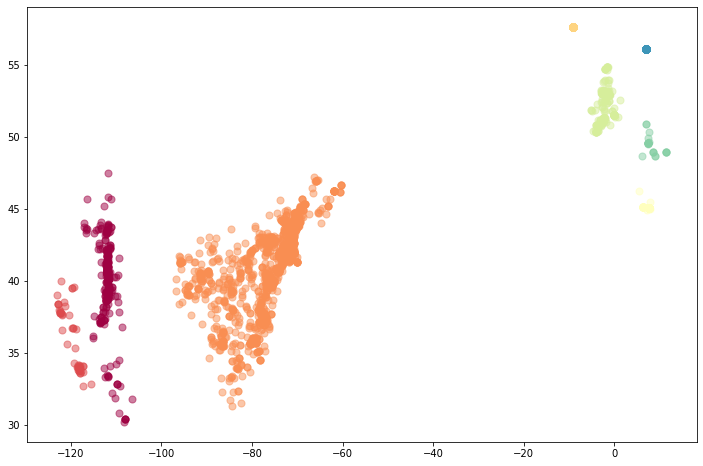

In [21]:
# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(12,8))
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)
    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)
    ## Plot the outliers
    #xy = X[class_member_mask & ~core_samples_mask]
    #plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

**Observations:**

This was interesting, and I like ignoring the outliers, but the largest cluster covers too large a distance, almost half of the U.S.  It would be nice to get a map under this, but I can tell the lower left is the North American west coast, the orange is the US East coast, and the upper right is Europe and Scandinavia. In general, the clusters are too large, and it appears that DBSCAN won't help us as much as I had hoped.

It's also clear that the most clusterable data lies between -140 and 20 longitude, and between 25 and 60 latitude.  So we'll adjust our data, losing a few data points, but still holding to over 2600 events:

In [22]:
#Lets limit the data to where we know we can have clusters of significance
sdf = df[df['LONG']>=-140.0]
sdf = sdf[sdf['LONG']<=20.0] 
sdf = sdf[sdf['LAT']>=25.0]
sdf = sdf[sdf['LAT']<=60.0]
X = sdf[['LONG','LAT']].values
print(len(X))

2622


### Agglomerative Clustering
For this kind of clustering, we make a choice of how many clusters we want.  The game here is to fit a group of clusters that would be of reasonable size to be of interest to researchers, not covering tracts of land that are too large.  In exploring, I found 60 to be a good number.

In [23]:
from matplotlib import pyplot as plt 
from sklearn.cluster import AgglomerativeClustering 

In [29]:
agglom = AgglomerativeClustering(n_clusters = 60, linkage = 'average').fit(X)
#print(set(agglom.labels_))

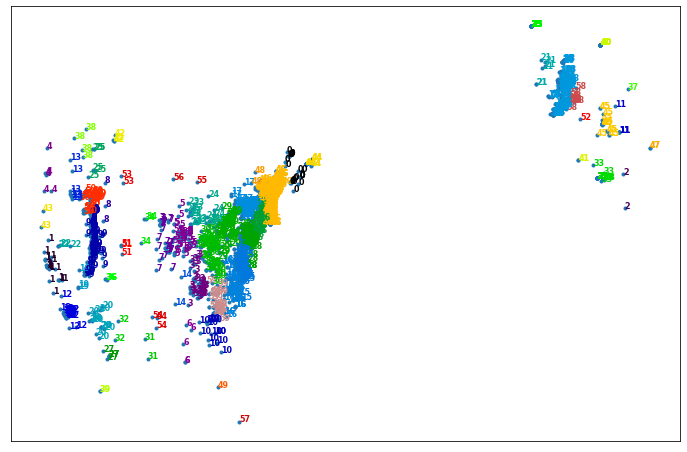

In [30]:
# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(12,8))
  
# These two lines of code are used to scale the data points down,
# Or else the data points will be scattered very far apart.

# Create a minimum and maximum range of X.
x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)

# Get the average distance for X.
X1 = (X - x_min) / (x_max - x_min)

# This loop displays all of the datapoints.
for i in range(X1.shape[0]):
    # Replace the data points with their respective cluster value 
    # (ex. 0) and is color coded with a colormap (plt.cm.spectral)
    plt.text(X1[i, 0], X1[i, 1],str(agglom.labels_[i]),
        color=plt.cm.nipy_spectral(agglom.labels_[i] / len(set(agglom.labels_))),
        fontdict={'weight': 'bold', 'size': 8})
    
# Remove the x ticks, y ticks, x and y axis
plt.xticks([])
plt.yticks([])
#plt.axis('off')

# Display the plot of the original data before clustering
plt.scatter(X1[:, 0], X1[:, 1], marker='.')
# Display the plot
plt.show()

**Observations:**

This one was nice, and I liked have more groups in smaller defined areas.  Some of the clusters stretch further than I would like.  It's a possibility though.

### K-Means Clustering
Again we need to choose the number of clusters.  I liked 60 before, so we'll use that.  

We also need to choose how many iterations to run.  We have a lot of data, and a lot of cluster centers, so we'll run with some high n_init values.

In [32]:
import random 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [41]:
x = StandardScaler().fit_transform(X)
clusterNum = 40
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 200)
k_means.fit(x)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
#k_means_cluster_centers

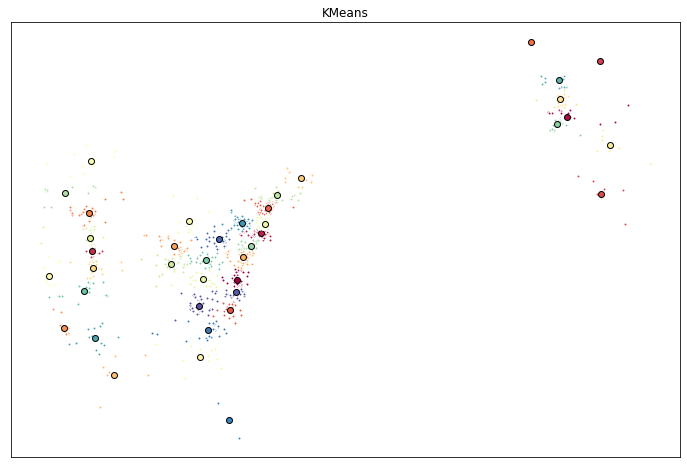

In [42]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len(k_means_cluster_centers)), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(x[my_members, 0], x[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()


**Observations:**

I like the K_Means clusters the best.  The clusters look reasonable.  So we'll use it as our cluster definition:

In [66]:
#Add the cluster values to the trimmed Dataframe
choice = 'k-means'  #or 'agg'
if choice =='k-means':
    sdf['CLUSTER']=k_means_labels
elif choice == 'agg':
    sdf['CLUSTER']=agglom.labels_

### 3 - Statistics and Ranking
The statistics for the clusters include:
- Cluster ID
- Count of events in the cluster
- Average percent completion score
- Priority Ranking
​
The **average percent completion score** is the sum of all event completion scores, divided by the number of events in the cluster.
​
**Priority Ranking** is based on 2 scores:  
1. The count of events in the cluster, divided by the maximum count across clusters (a percent). The more events in a cluster, the higher it will rank.
2. The average percent completion score.  But we want less completion to get a higher rank, so the calculation involves subtracting the percentage from 1 (1-score).
​
We'll average these two values for each cluster, and sort them in order of their values.  The highest score gets a ranking of 1, the next highest is 2, and so on.

In [62]:
#dictionary: key = cluster, value = [count-events, completion-score, rank]
d={}

#initialize dictionary with count of events under cluster labels, zero for completion_score, None for rank
if choice == 'k-means':
    for lab in set(k_means_labels):
        d[lab]=[np.count_nonzero(k_means_labels == lab),0,None]
elif choice == 'agg':
    for lab in set(agglom.labels_):
        d[lab]=[np.count_nonzero(agglom.labels_ == lab),0,None]
    
#sum completion_scores in the dictionary
for row in sdf[['COMPLETION_SCORE','CLUSTER']].values:
    d[row[1]][1] += row[0]

#compute the average percent completion score and replace the sum in the dictionary
#create lists for cluster counts and completion scores to use in ranking
rank_count = []
rank_complete = []
for key, value in d.items():
    d[key][1] = value[1]/value[0]          #sum of scores/number of events = avg completion score
    rank_count.append([value[0], key])     #count, cluster
    rank_complete.append([d[key][1], key]) #average-completion-score, cluster
    
## find the maximum values to use in ranking calculations
max_count=max(rank_count)
max_complete=max(rank_complete)

#compute rank to prioritize clusters with high event counts and low completion scores
ranks = []    #list of [rank, cluster]
for i,j in zip(rank_count, rank_complete):
    ranks.append( [ (float(i[0])/max_count[0] + (1.0-(j[0])))/2.0, i[1] ] )
ranks = sorted(ranks)
ranks.reverse()
for rank in range(len(ranks)):
    d[ranks[rank][1]][2] = rank+1
    
#create a dataframe to hold the cluster-level information
cols = ['COUNT','AVG_COMPLETE', 'RANK']
rankings = pd.DataFrame(d).transpose()
rankings.columns = cols
rankings.reset_index(inplace=True)
rankings = rankings.rename(columns = {'index':'CLUSTER'})
rankings = rankings.sort_values(by='RANK')
rankings.head()

,CLUSTER,COUNT,AVG_COMPLETE,RANK
7,7,284.0,0.181118,1.0
4,4,225.0,0.160278,2.0
2,2,216.0,0.186053,3.0
8,8,169.0,0.153476,4.0
22,22,155.0,0.202016,5.0


**Observations:**

We've gotten a good ranking system.  We can see that the top clusters have a low completion score, with high numbers of events in them.  Nice. But it still doesn't mean anything to a client.  Where are these clusters specifically?

So let's extract more information into the rankings.  Let's add 2 columns - one for COUNTRIES, and one for STATES (if in the U.S.), and populate them with information.  The values that go into these columns are best added to the sdf dataframe.

For this, we need a few more lists.  I've previously webscraped a list of countries in the world, and a list of states in the U.S. and saved them as CSV files.  We'll use those.

### 4 - Ranked Cluster Report
This report presents statistics on the clusters: the rank, number of events in the cluster, the average percent complete of the events (sources).  In addition, we need to know the countries and/or states included in the cluster.  It might be that clients pick a specific country or state to focus on instead of everything in a cluster.  Choosing a cluster is nice, because it includes people who are likely related, even if they cross state/country lines.  (For this project, we assume a cluster is desired.)

In [63]:
#add countries and states to the Rankings dataframe
#ensure that dataframe sdf has the cluster recorded in it
sdf.head()
#
#For each cluster, get a dataframe of the events for that cluster
add_rank_countries = []
add_rank_states = []
rdf_list = []
for r in rankings['CLUSTER'].values:
    rdf = sdf[sdf['CLUSTER']==r]
    rdf_list.append([r,rdf])  #cluster number and dataframe
    ##COUNTRIES
    #get a set of countries from the events dataframe
    country_list = set(rdf['COUNTRY'].tolist())
    countries = []
    #remove np.nan values - you have to convert them to string to recognize them
    for c in country_list:
        if str(c) == 'nan':
            continue
        if c not in countries:
            countries.append(c)
    #Join all the unique countries into a string, separated by ;
    add_rank_countries.append("; ".join(countries))
    ##STATES
    #get a list of states from the events dataframe
    the_states = rdf['STATE'].tolist()
    #There may be multiple states in the strings; break them up
    state_list = []
    for states in the_states:
        breakup = str(states).split(';')
        for state in breakup:
            state_list.append(state.strip())
    #make the state list a set to eliminate duplicates quickly
    state_list = set(state_list)
    states = []
    #remove np.nan values
    for c in state_list:
        if str(c) == 'nan':
            continue
        if c not in states:
            states.append(c)
    #Join all the unique states into a string, separated by ;
    add_rank_states.append("; ".join(states))
# add the state and country lists to the rankings dataframe
rankings['COUNTRIES'] = add_rank_countries
rankings['STATES'] = add_rank_states
rankings

,CLUSTER,COUNT,AVG_COMPLETE,RANK,COUNTRIES,STATES
7,7,284.0,0.181118,1.0,Canada; United States,New York; Vermont; Washington; Massachusetts; ...
4,4,225.0,0.160278,2.0,Denmark,
2,2,216.0,0.186053,3.0,United States,Pennsylvania; New York; Rhode Island; Washingt...
8,8,169.0,0.153476,4.0,United Kingdom,
22,22,155.0,0.202016,5.0,United States,New York; Vermont; Massachusetts; New Hampshir...
12,12,128.0,0.149902,6.0,Lebanon; United States,Delaware; Pennsylvania; New Jersey; Washington...
5,5,79.0,0.101266,7.0,Italy; France,
16,16,93.0,0.192876,8.0,United Kingdom; Ireland,
24,24,93.0,0.219758,9.0,United States,Idaho; Wyoming; California; Utah; Oregon
0,0,69.0,0.161232,10.0,United States,Delaware; Washington; Virginia; Maryland


**Observations:**

There's obviously still some dirty data in here, but most of it looks like it should, and we're working with large numbers.  We can continue with our reports to the client. 

### 5 - Cluster Detail Report
Once a cluster or location is selected, the client needs a list of persons and events that are in the cluster.  This helps them find the people they need to research.  They likely want the information sorted by location then date.  (For this project, I presume they choose a cluster, not a specific country or state.)

 We have dataframes available to work with:
- **df** is a pandas dataframe that contains the original wrangled data
- **sdf** is a geographically restricted subset of df, with clusters and scores
- **rankings** is a dataframe containing statistics and information about the clusters on the data.

We also have **rdf_list**, which is a list of dataframes for each cluster.  This and **rankings** are our most valuable assets for these reports.

We'll assume the client is interested in keeping their research within the U.S. and chooses the first cluster in the U.S. and no other country.  The output will be a text file describing the cluster, and a csv file containing the details of the events in the cluster.  These will be passed on to the client.

In [64]:
#Get the info for the cluster rank that is in only the U.S.
us_ranks = rankings[rankings['COUNTRIES'] == "United States"]
client_cluster_data = us_ranks.values[0]
client_cluster = client_cluster_data[0]
client_rank = int(client_cluster_data[3])

# get the dataframe for the cluster's individual events
rdf = None
for item in rdf_list:
    if item[0] == client_cluster:
        rdf = item[1]
        break
#rdf.head()
client_cluster_data

array([2, 216.0, 0.18605324074074073, 3.0, 'United States',
       'Pennsylvania; New York; Rhode Island; Washington; Massachusetts; Connecticut'],
      dtype=object)

In [65]:
# Names of output files
cluster_file = 'cluster_info.txt'
events_file = 'cluster_events.csv'

#Create a text file for the client describing the cluster.
if client_cluster_data[4] != '':
    if ';' in client_cluster_data[4]:
        my_countries = client_cluster_data[4].split(';')
        my_countries = ', '.join(my_states)
    else:
        my_countries = client_cluster_data[4]                
report = 'REPORT ON CLUSTER\n\n- This cluster contains events that reside in these countries: '+ my_countries + '.\n\n'
if client_cluster_data[5] != '':
    if ';' in client_cluster_data[5]:
        my_states = client_cluster_data[5].split(';')
        my_states = ', '.join(my_states)
    else:
        my_states = client_cluster_data[5]
    report +='- It spans these states: '+ my_states+ '.\n\n'
report += 'The attachment of sources to facts is vital to providing evidence that information is true. '
report += 'Quality of sources can only be determined by researchers. '
report += 'This report searched for the number of sources present for each event as a measure of completeness. '
report += 'Results show that completeness of source gathering in this cluster averages at '+ str(int(100*client_cluster_data[2])) +'%.\n\n'
report += 'There are '+str(int(client_cluster_data[1]))+ ' vital events in this cluster, '
report += 'which are contained in a separate CSV file named "'+events_file+'".'

with open(cluster_file, 'w', encoding = 'latin-1') as f:
    f.write(report)
    
#Create a CSV file for the events in the cluster.
rdf = rdf[['ID','NAME','GENDER','EVENT_TYPE','DATE','LAT','LONG',
            'LOCATION','COUNTRY','STATE','COMPLETION_SCORE','CLUSTER']]
rdf.head()
rdf.to_csv(events_file)
print(report)
print("\n------------------------------------EVENTS------------------------------------------\n")
rdf.head()

REPORT ON CLUSTER

- This cluster contains events that reside in these countries: United States.

- It spans these states: Pennsylvania,  New York,  Rhode Island,  Washington,  Massachusetts,  Connecticut.

The attachment of sources to facts is vital to providing evidence that information is true. Quality of sources can only be determined by researchers. This report searched for the number of sources present for each event as a measure of completeness. Results show that completeness of source gathering in this cluster averages at 18%.

There are 216 vital events in this cluster, which are contained in a separate CSV file named "cluster_events.csv".

------------------------------------EVENTS------------------------------------------



,ID,NAME,GENDER,EVENT_TYPE,DATE,LAT,LONG,LOCATION,COUNTRY,STATE,COMPLETION_SCORE,CLUSTER
19,I500014,Charlotte /Churchill/,F,BIRTH,1 NOV 1771,41.883436,-70.762538,Carver; Plymouth; Massachusetts; United States,United States,Massachusetts,0.25,2
36,I500026,David /Goff/,M,BIRTH,ABT 1749,41.746497,-74.084489,of New Paltz; Ulster; N.Y.,NaN,NaN,0.25,2
37,I500026,David /Goff/,M,MARRIAGE,1785,41.928781,-74.002370,Kingston; Ulster Co; New York; USA,NaN,New York,0.25,2
72,I500048,Rhoda /Partridge/,F,BIRTH,ABT 1759,42.141335,-71.519202,Milford; Worcester; Mass.,NaN,NaN,0.25,2
79,I500051,David /Partridge/,M,BIRTH,26 JAN 1746,42.200097,-71.424505,Holliston;Middlesex;Massachusetts,NaN,Massachusetts,0.25,2


## Results

And there we have it - we:
- Wrangled a really messy GEDCOM into something we could use (done beforehand)
- Visualized the data on a map
- Created clusters 3 different ways, and selected the best one for this project
- Ranked the clusters and created statistics for making a choice of research area
- Created a report about the clusters
- Created and saved to output files 2 reports about a chosen cluster

## Discussion
A Few Observations:
- After wrangling and adjusting our data, we had over 2600 events with geocode data, which was a good sampling of the data. As we got into useful output, there were still some surprises, which surprisingly isn't a surprise.  Does that surprise you? :D
- The completion scores are not high, meaning researchers are not recording their sources in the family tree tools. I doubt they are holding them privately, although some might.  It's what happens when the general public collaborates, and everyone hates writing source citations (LOL!)  
- Greater weight is given to density of events at a geographic location than completion scores in making a decision.  This is natural, because learning a location and it's history well enough to do research there is a steep learning curve.  Researchers like to narrow into an area and its immediate surroundings.
- Running these routines again creates different results.  So if this were to become a service, it might be worth saving all results when this is run instead of the two files regarding the chosen cluster.
- I did not address divisions by time periods (in decades) for events.  I suppose if I were to continue with this idea, a 3D graph where 2 dimensions are a geo-coordinates and 1 dimension represents time periods in decades.  Clustering on that might be interesting and insightful.

## Conclusions and Future
I think this kind of report could be helpful for people assessing the research needs of their family tress.  I've been at my family history for a while, and these reports showed about what I expected in terms of where _my_ greatest research needs are. 

If I were to attempt to use this with others, I would want a better way to clean data.  In some ways it's like trying to read handwriting - so many researchers over the years recording data in so many ways.  I would probably look towards machine-learning, and develop a robust set of training, validation, and test samples.

I would also search for a way to geocode that takes into account the changes in jurisdiction boundaries over time.  The Getty Thesaurus is a possibility, but it's a mass of confusion to learn to use, and I don't know how accurate it is - whether it would be worth the trouble - yet.

And with those projections, maybe I'm in way over my head. Fun, though.

### By Sonja Thompson
May 2021

Fort Collins, CO, USA

sthompsonbusy@gmail.com